In [1]:
using Distributions
using HypothesisTests
using Random
using StatsPlots
default(fmt=:png, tickfontsize=6, titlefontsize=12)

ECDF(A, x) = count(≤(x), A)/length(A)

function degree_of_freedom_Welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function plot_t_tests(;
        distx = Normal(),
        disty = Normal(),
        m = 10, 
        n = 10,
        s = 1,
        L = 10^6,
        ytick = 0:0.01:1,
        ylim = :auto,
        legend = :bottom,
        bin = :auto
    )
    println("(distribution of X) = distx = ", distx) 
    println("(distribution of Y) = disty = ", disty)
    println("(size of sample from X) = m = ", m)
    println("(size of sample from Y) = n = ", n)
    if s != 1 println("multiple of disty = ", s) end
    println()
    
    @show mean(distx)
    if s == 1 @show(mean(disty)) else @show(s*mean(disty)) end
    @show std(distx)
    if s == 1 @show(std(disty)) else @show(abs(s)*std(disty)) end
    println()
    
    T_Student = Vector{Float64}(undef, L)
    T_Welch = Vector{Float64}(undef, L)
    
    df_Student = m + n - 2
    DF_Welch = Vector{Float64}(undef, L)
    
    Xtmp = [Vector{eltype(distx)}(undef, m) for _ in 1:Threads.nthreads()]
    Ytmp = [Vector{eltype(disty)}(undef, n) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        X = rand!(distx, Xtmp[tid])
        Y = rand!(disty, Ytmp[tid])
    
        X̄ = mean(X)
        Ȳ = s*mean(Y)
        SX = std(X)
        SY = std(Y)
        S = √(((m-1)*SX^2 + (n-1)*SY^2)/(m+n-2))

        T_Student[i] = (X̄ - Ȳ)/(S*√(1/m + 1/n))
        T_Welch[i] = (X̄ - Ȳ)/√(SX^2/m + SY^2/n)
        
        DF_Welch[i] = degree_of_freedom_Welch(m, SX^2, n, SY^2)
    end
    @show T_Student ≈ T_Welch
    println()
    
    @show df_Student
    @show mean(DF_Welch) std(DF_Welch)
    println()

    pval_Student = @. 2ccdf(TDist(df_Student), abs(T_Student))
    pval_Welch = @. 2ccdf(TDist(DF_Welch), abs(T_Welch))

    @show ECDF(pval_Welch, 0.05)
    @show ECDF(pval_Student, 0.05)
    println()
    @show ECDF(pval_Welch, 0.01)
    @show ECDF(pval_Student, 0.01)
    println()
    
    P = plot()
    plot!(α -> ECDF(pval_Welch, α), 0, 0.1; label="Welch t-test")
    plot!(α -> ECDF(pval_Student, α), 0, 0.1; label="Student t-test", ls=:dot)
    plot!(identity, 0, 0.1; label="", ls=:dot, c=:black, alpha=3)
    plot!(; xtick=0:0.01:1, ytick, xrotation=90)
    plot!(; xguide="nominal significance level α",
        yguide="probability of p-value ≤ α")
    plot!(; legend=:outertop, legendfontsize=10)
    
    Q = plot()
    plot!(α -> ECDF(pval_Welch, α), 0, 1; label="Welch t-test")
    plot!(α -> ECDF(pval_Student, α), 0, 1; label="Student t-test", ls=:dot)
    plot!(identity, 0, 1; label="", ls=:dot, c=:black, alpha=0.3)
    plot!(; xtick=0:0.05:1, ytick=0:0.05:1, xrotation=90)
    plot!(; xguide="nominal significance level α",
        yguide="probability of p-value ≤ α")
    plot!(; legend=:outertop, legendfontsize=10)

    #Q = plot()
    #stephist!(pval_Welch; norm=true, bin, label="Welch t-test")
    #stephist!(pval_Student; norm=true, bin, label="Student t-test", ls=:dot)
    #plot!(; xguide="P-value", yguide="probability density")
    #plot!(; xtick=0:0.05:1, ytick=0:0.1:5, xrotation=90)
    #plot!(; legend=:outertop, legendfontsize=10, ylim)
    
    #plot(P, Q; size=(1000, 460), layout=@layout [a{0.4w} b])
    plot(P, Q; size=(700, 370), layout=(1, 2))
    plot!(; bottommargin=4Plots.mm, leftmargin=4Plots.mm)
end

function plot_df_and_tstatratio(;
        m = 9,
        n = 11,
        tick = Any[0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
    )
    log10tick = (tick, string.(tick))
    as = 10.0 .^ range(log10(minimum(tick)), log10(maximum(tick)), 1000)

    P = plot(as, a -> degree_of_freedom_Welch(m, 1, n, a^2); label="Welch t-test")
    hline!([(m-1)+(n-1)]; label="Student t-test", ls=:dash)
    hline!([min(m-1, n-1)]; label="min(m-1, n-1)", ls=:dashdot)
    hline!([max(m-1, n-1)]; label="max(m-1, n-1)", ls=:dashdotdot)
    vline!([√((n*(n-1))/(m*(m-1)))]; label="√((n*(n-1))/(m*(m-1)))", ls=:dot)
    vline!([1]; label="", ls=:dot, c=:gray)
    plot!(xscale=:log10, xtick=log10tick)
    plot!(xguide="std(sample of Y) / std(sample of X)")
    title!("degree of freedom for m = $m, n = $n")

    Q = plot(as, a -> √(1/m + a^2/n) / √((((m-1)+(n-1)*a^2)/(m-1+n-1))*(1/m+1/n));
        label="t_Student / t_Welch")
    hline!([√(m/n), √(n/m)]; label="√(m/n), √(n/m)", ls=:dash)
    vline!([1]; label="", ls=:dot, c=:gray)
    plot!(xscale=:log10, xtick=log10tick)
    plot!(xguide="std(sample of Y) / std(sample of X)")
    plot!(ylim=(0.9, 1.1) .* minmax(√(m/n), √(n/m)))
    title!("t_Student / t_Welch for m = $m,  n = $n")

    plot(P, Q; size=(1000, 400))
    plot!(bottommargin=4Plots.mm)
end

plot_df_and_tstatratio (generic function with 1 method)

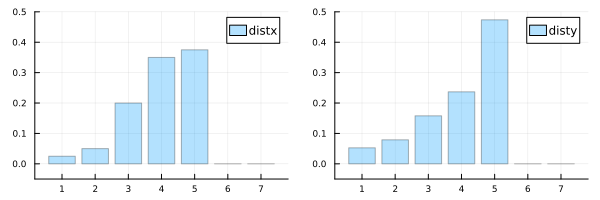

(distribution of X) = distx = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(7)
p: [0.025, 0.05, 0.2, 0.35, 0.375, 0.0, 0.0]
)

(distribution of Y) = disty = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(7)
p: [0.05263157894736842, 0.07894736842105263, 0.15789473684210525, 0.23684210526315788, 0.47368421052631576, 0.0, 0.0]
)

(size of sample from X) = m = 20
(size of sample from Y) = n = 14

mean(distx) = 4.0
mean(disty) = 3.9999999999999996
std(distx) = 1.0
std(disty) = 1.1920791213585393

T_Student ≈ T_Welch = false

df_Student = 32
mean(DF_Welch) = 24.951575813641444
std(DF_Welch) = 4.195766720118777

ECDF(pval_Welch, 0.05) = 0.05356
ECDF(pval_Student, 0.05) = 0.058968

ECDF(pval_Welch, 0.01) = 0.012953
ECDF(pval_Student, 0.01) = 0.012836



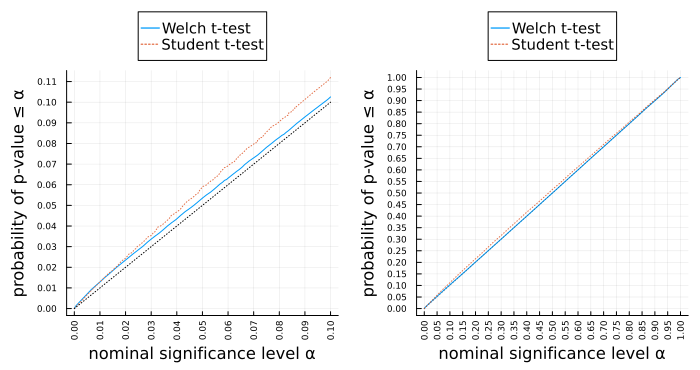

In [2]:
fx = [5, 10, 40, 70, 75, 0, 0]
px = fx / sum(fx)
distx = Categorical(px)

fy = [10, 15, 30, 45, 90, 0, 0]
py = fy / sum(fy)
disty = Categorical(py)

P = bar(distx; alpha=0.3, label="distx", ylim=(-0.05, 0.5))
Q = bar(disty; alpha=0.3, label="disty", ylim=(-0.05, 0.5))
plot(P, Q; size=(600, 200)) |> display

plot_t_tests(; distx, disty, m=20, n=14, ytick=0:0.01:1, ylim=(-0.05, 2), bin=0:0.01:1.01)

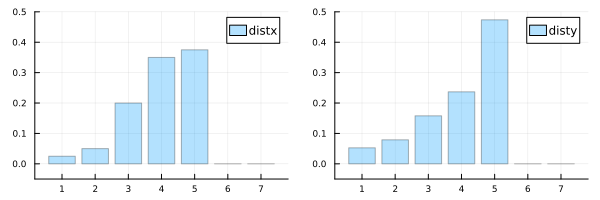

(distribution of X) = distx = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(7)
p: [0.025, 0.05, 0.2, 0.35, 0.375, 0.0, 0.0]
)

(distribution of Y) = disty = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(7)
p: [0.05263157894736842, 0.07894736842105263, 0.15789473684210525, 0.23684210526315788, 0.47368421052631576, 0.0, 0.0]
)

(size of sample from X) = m = 20
(size of sample from Y) = n = 20

mean(distx) = 4.0
mean(disty) = 3.9999999999999996
std(distx) = 1.0
std(disty) = 1.1920791213585393

T_Student ≈ T_Welch = true

df_Student = 38
mean(DF_Welch) = 35.28273041837863
std(DF_Welch) = 2.8055709604083203

ECDF(pval_Welch, 0.05) = 0.050001
ECDF(pval_Student, 0.05) = 0.0511

ECDF(pval_Welch, 0.01) = 0.009892
ECDF(pval_Student, 0.01) = 0.010503



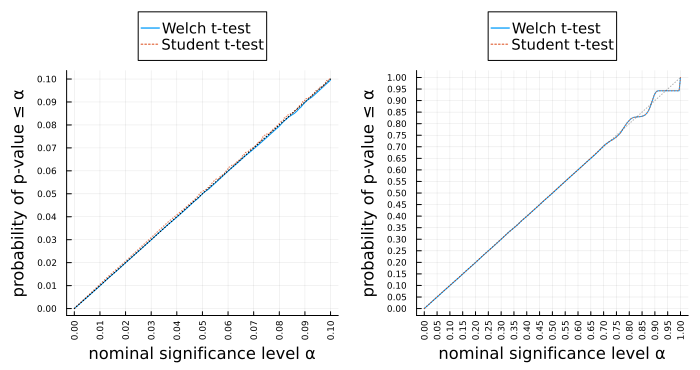

In [3]:
fx = [5, 10, 40, 70, 75, 0, 0]
px = fx / sum(fx)
distx = Categorical(px)

fy = [10, 15, 30, 45, 90, 0, 0]
py = fy / sum(fy)
disty = Categorical(py)

P = bar(distx; alpha=0.3, label="distx", ylim=(-0.05, 0.5))
Q = bar(disty; alpha=0.3, label="disty", ylim=(-0.05, 0.5))
plot(P, Q; size=(600, 200)) |> display

plot_t_tests(; distx, disty, m=20, n=20, ytick=0:0.01:1, ylim=(-0.05, 2), bin=0:0.01:1.01)

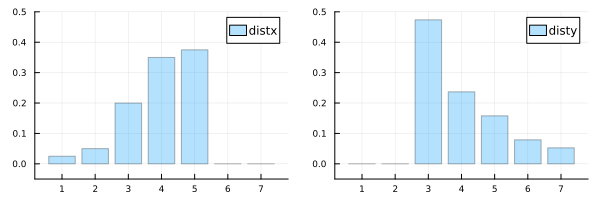

(distribution of X) = distx = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(7)
p: [0.025, 0.05, 0.2, 0.35, 0.375, 0.0, 0.0]
)

(distribution of Y) = disty = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(7)
p: [0.0, 0.0, 0.47368421052631576, 0.23684210526315788, 0.15789473684210525, 0.07894736842105263, 0.05263157894736842]
)

(size of sample from X) = m = 20
(size of sample from Y) = n = 20

mean(distx) = 4.0
mean(disty) = 4.0
std(distx) = 1.0
std(disty) = 1.1920791213585393

T_Student ≈ T_Welch = true

df_Student = 38
mean(DF_Welch) = 35.28158131420527
std(DF_Welch) = 2.8039740327432887

ECDF(pval_Welch, 0.05) = 0.056043
ECDF(pval_Student, 0.05) = 0.056714

ECDF(pval_Welch, 0.01) = 0.015219
ECDF(pval_Student, 0.01) = 0.015478



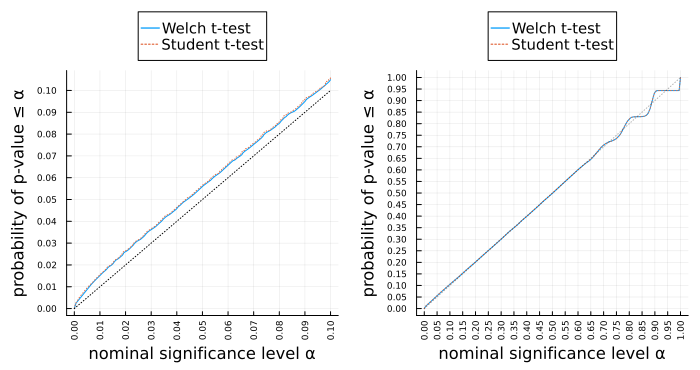

In [4]:
fx = [5, 10, 40, 70, 75, 0, 0]
px = fx / sum(fx)
distx = Categorical(px)

fy = reverse([10, 15, 30, 45, 90, 0, 0])
py = fy / sum(fy)
disty = Categorical(py)

P = bar(distx; alpha=0.3, label="distx", ylim=(-0.05, 0.5))
Q = bar(disty; alpha=0.3, label="disty", ylim=(-0.05, 0.5))
plot(P, Q; size=(600, 200)) |> display

plot_t_tests(; distx, disty, m=20, n=20, ytick=0:0.01:1, ylim=(-0.05, 2), bin=0:0.01:1.01)

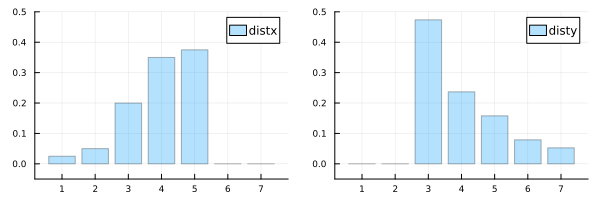

(distribution of X) = distx = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(7)
p: [0.025, 0.05, 0.2, 0.35, 0.375, 0.0, 0.0]
)

(distribution of Y) = disty = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(7)
p: [0.0, 0.0, 0.47368421052631576, 0.23684210526315788, 0.15789473684210525, 0.07894736842105263, 0.05263157894736842]
)

(size of sample from X) = m = 40
(size of sample from Y) = n = 40

mean(distx) = 4.0
mean(disty) = 4.0
std(distx) = 1.0
std(disty) = 1.1920791213585393

T_Student ≈ T_Welch = true

df_Student = 78
mean(DF_Welch) = 74.06266456609552
std(DF_Welch) = 4.050083378084914

ECDF(pval_Welch, 0.05) = 0.052877
ECDF(pval_Student, 0.05) = 0.053102

ECDF(pval_Welch, 0.01) = 0.012677
ECDF(pval_Student, 0.01) = 0.012751



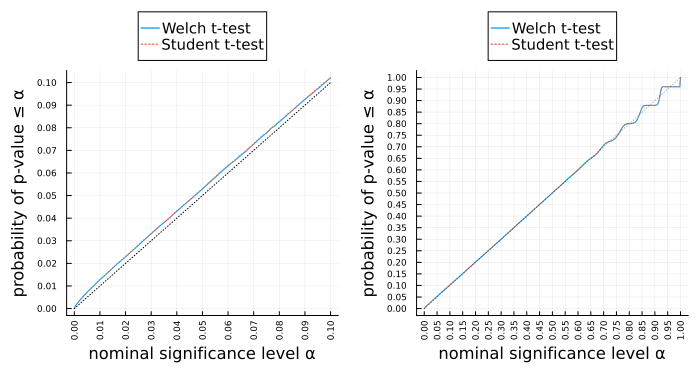

In [5]:
fx = [5, 10, 40, 70, 75, 0, 0]
px = fx / sum(fx)
distx = Categorical(px)

fy = reverse([10, 15, 30, 45, 90, 0, 0])
py = fy / sum(fy)
disty = Categorical(py)

P = bar(distx; alpha=0.3, label="distx", ylim=(-0.05, 0.5))
Q = bar(disty; alpha=0.3, label="disty", ylim=(-0.05, 0.5))
plot(P, Q; size=(600, 200)) |> display

plot_t_tests(; distx, disty, m=40, n=40, ytick=0:0.01:1, ylim=(-0.05, 2), bin=0:0.01:1.01)

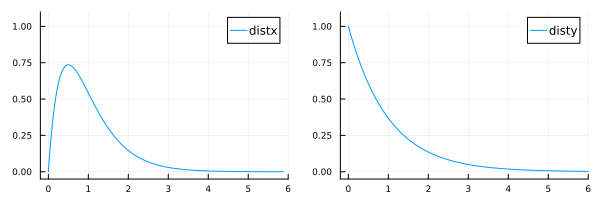

(distribution of X) = distx = Gamma{Float64}(α=2.0, θ=0.5)
(distribution of Y) = disty = Exponential{Float64}(θ=1.0)
(size of sample from X) = m = 20
(size of sample from Y) = n = 20

mean(distx) = 1.0
mean(disty) = 1.0
std(distx) = 0.7071067811865476
std(disty) = 1.0

T_Student ≈ T_Welch = true

df_Student = 38
mean(DF_Welch) = 32.96738804417818
std(DF_Welch) = 4.392619759449354

ECDF(pval_Welch, 0.05) = 0.052057
ECDF(pval_Student, 0.05) = 0.053623

ECDF(pval_Welch, 0.01) = 0.011066
ECDF(pval_Student, 0.01) = 0.011807



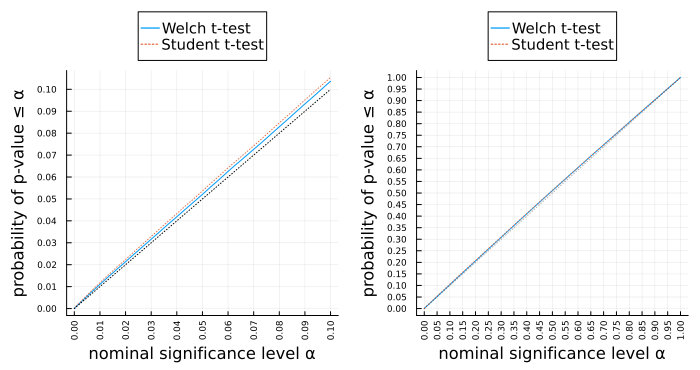

In [6]:
distx = Gamma(2, 1/2)
disty = Exponential()

P = plot(distx; label="distx", xlim=(-0.2, 6), ylim=(-0.05, 1.1))
Q = plot(disty; label="disty", xlim=(-0.2, 6), ylim=(-0.05, 1.1))
plot(P, Q; size=(600, 200)) |> display

plot_t_tests(; distx, disty, m=20, n=20, ytick=0:0.01:1, ylim=(-0.05, 2), bin=0:0.01:1.01)